# 1. 라이브러리 임포트 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 경고 숨기기
import warnings
warnings.filterwarnings('ignore')

import re

import nltk
import nltk.data
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn import metrics, preprocessing, pipeline, model_selection, naive_bayes
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
import xgboost as xgb

import time

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GlobalAveragePooling1D, Conv1D, MaxPooling1D, Flatten, Embedding, BatchNormalization
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 66.2 MB/s eta 0:00:00


In [4]:
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
from textstat import flesch_reading_ease

# 필요한 리소스 다운로드 (최초 1회만)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
import nltk

# 필요한 NLTK 리소스 모두 다운로드
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test_x.csv')

In [8]:
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [9]:
test.head()

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


# 2. 파생변수 생성

## (1) 길이 기반

In [10]:
def add_sentence_features(df):
    df = df.copy()

    # 단어 리스트 생성
    df['word_list'] = df['text'].apply(lambda x: x.split())

    # ① 문장 내 평균 단어 길이
    df['average_word'] = df['word_list'].apply(
        lambda words: sum(len(w) for w in words) / len(words) if len(words) > 0 else 0
    )

    # ② 문장 내 고유 단어 개수
    df['unique_word'] = df['word_list'].apply(lambda words: len(set(words)))

    # ③ 총 문장 길이 (문장 수)
    df['total_sentence'] = df['text'].apply(
        lambda x: len([s for s in re.split(r'[.!?]', x) if s.strip() != ''])
    )

    # 중간 계산용 컬럼 제거
    df.drop(columns=['word_list'], inplace=True)

    return df

# 적용
train = add_sentence_features(train)
test = add_sentence_features(test)

# 결과 확인
train.head()

,index,text,author,average_word,unique_word,total_sentence
0,0,"He was almost choking. There was so much, so m...",3,4.239130,39,3
1,1,"“Your sister asked for it, I suppose?”",2,4.571429,7,2
2,2,"She was engaged one day as she walked, in per...",1,4.614035,50,3
3,3,"The captain was in the porch, keeping himself ...",4,4.517241,49,7
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,4.871795,36,6


## (2) 문장 부호 기반

In [11]:
# 문장부호 비율 파생변수 생성 함수
def add_punctuation_features(df):
    df = df.copy()
    text_len = df['text'].str.len()

    # 각 문장부호 개수
    df['period_pro'] = df['text'].str.count(r'[.,]') / text_len
    df['ques_pro'] = df['text'].str.count(r'\?') / text_len
    df['excla_pro'] = df['text'].str.count(r'!') / text_len
    df['hyp_pro'] = df['text'].str.count(r'-') / text_len
    df['quot_pro'] = df['text'].str.count(r'["“”‘’\']') / text_len
    df['colon_pro'] = df['text'].str.count(r'[:;]') / text_len

    return df

# 적용
train = add_punctuation_features(train)
test = add_punctuation_features(test)

# 확인
train.head()


,index,text,author,average_word,unique_word,total_sentence,period_pro,ques_pro,excla_pro,hyp_pro,quot_pro,colon_pro
0,0,"He was almost choking. There was so much, so m...",3,4.239130,39,3,0.029167,0.000000,0.000000,0.0,0.000000,0.004167
1,1,"“Your sister asked for it, I suppose?”",2,4.571429,7,2,0.026316,0.026316,0.000000,0.0,0.052632,0.000000
2,2,"She was engaged one day as she walked, in per...",1,4.614035,50,3,0.025000,0.000000,0.000000,0.0,0.003125,0.003125
3,3,"The captain was in the porch, keeping himself ...",4,4.517241,49,7,0.047022,0.000000,0.000000,0.0,0.009404,0.006270
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,4.871795,36,6,0.043860,0.000000,0.008772,0.0,0.026316,0.004386


## (3) 언어적 특성

In [12]:
def add_linguistic_features(df):
    df = df.copy()

    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
    adj_tags = ['JJ', 'JJR', 'JJS']
    adv_tags = ['RB', 'RBR', 'RBS']
    art_tags = ['DT']  # 관사 (a, an, the 등)

    # 각 문장별 품사 분석 기반 비율 계산
    def pos_ratios(text):
        words = word_tokenize(text)
        if len(words) == 0:
            return 0, 0, 0, 0
        tagged = pos_tag(words)
        total = len(tagged)
        noun_ratio = sum(1 for w, t in tagged if t in noun_tags) / total
        adj_ratio = sum(1 for w, t in tagged if t in adj_tags) / total
        adv_ratio = sum(1 for w, t in tagged if t in adv_tags) / total
        art_ratio = sum(1 for w, t in tagged if t in art_tags) / total
        return noun_ratio, adj_ratio, adv_ratio, art_ratio

    df[['noun_pro', 'adj_pro', 'adv_pro', 'art_pro']] = df['text'].apply(
        lambda x: pd.Series(pos_ratios(x))
    )

    # 가독성 지표 (Flesch Reading Ease)
    df['reading'] = df['text'].apply(lambda x: flesch_reading_ease(x))

    # 감성 점수 (TextBlob polarity)
    df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    # 대문자 비율: 완전히 대문자인 단어 개수 비율
    df['cap_pro'] = df['text'].apply(
        lambda x: sum(1 for w in x.split() if w.isupper()) / len(x.split()) if len(x.split()) > 0 else 0
    )

    return df

# 적용
train = add_linguistic_features(train)
test = add_linguistic_features(test)

# 결과 확인
train.head()

,index,text,author,average_word,unique_word,total_sentence,period_pro,ques_pro,excla_pro,hyp_pro,quot_pro,colon_pro,noun_pro,adj_pro,adv_pro,art_pro,reading,sentiment,cap_pro
0,0,"He was almost choking. There was so much, so m...",3,4.239130,39,3,0.029167,0.000000,0.000000,0.0,0.000000,0.004167,0.148148,0.055556,0.092593,0.037037,80.923841,0.125000,0.000000
1,1,"“Your sister asked for it, I suppose?”",2,4.571429,7,2,0.026316,0.026316,0.000000,0.0,0.052632,0.000000,0.181818,0.000000,0.000000,0.000000,90.958571,0.000000,0.142857
2,2,"She was engaged one day as she walked, in per...",1,4.614035,50,3,0.025000,0.000000,0.000000,0.0,0.003125,0.003125,0.179104,0.014925,0.074627,0.059701,64.360526,0.133333,0.000000
3,3,"The captain was in the porch, keeping himself ...",4,4.517241,49,7,0.047022,0.000000,0.000000,0.0,0.009404,0.006270,0.246753,0.038961,0.025974,0.129870,85.664448,-0.021212,0.000000
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,4.871795,36,6,0.043860,0.000000,0.008772,0.0,0.026316,0.004386,0.280702,0.052632,0.035088,0.070175,81.779538,0.000000,0.000000


## (4) 단어 빈도 기반

In [13]:
import pandas as pd
from collections import Counter
import numpy as np

def add_wordfreq_features(train_df, test_df, low_thresh=1, high_quantile=0.9):
    # 전체 말뭉치 단어 리스트 생성
    corpus = pd.concat([train_df['text'], test_df['text']]).tolist()
    words = [w for text in corpus for w in text.split()]

    # 단어 빈도 계산
    word_freq = Counter(words)

    # 상위 빈도 경계값(예: 90% 분위수) 계산
    high_threshold = np.quantile(list(word_freq.values()), high_quantile)

    def freq_ratios(text):
        word_list = text.split()
        if len(word_list) == 0:
            return 0, 0
        low_freq = sum(1 for w in word_list if word_freq[w] <= low_thresh)
        high_freq = sum(1 for w in word_list if word_freq[w] >= high_threshold)
        low_ratio = low_freq / len(word_list)
        high_ratio = high_freq / len(word_list)
        return low_ratio, high_ratio

    # 비율 계산 적용
    train_df[['low_fre_pro', 'high_fre_pro']] = train_df['text'].apply(lambda x: pd.Series(freq_ratios(x)))
    test_df[['low_fre_pro', 'high_fre_pro']] = test_df['text'].apply(lambda x: pd.Series(freq_ratios(x)))

    return train_df, test_df

# 적용
train, test = add_wordfreq_features(train, test)

# 결과 확인
train.head()

,index,text,author,average_word,unique_word,total_sentence,period_pro,ques_pro,excla_pro,hyp_pro,...,colon_pro,noun_pro,adj_pro,adv_pro,art_pro,reading,sentiment,cap_pro,low_fre_pro,high_fre_pro
0,0,"He was almost choking. There was so much, so m...",3,4.239130,39,3,0.029167,0.000000,0.000000,0.0,...,0.004167,0.148148,0.055556,0.092593,0.037037,80.923841,0.125000,0.000000,0.000000,0.978261
1,1,"“Your sister asked for it, I suppose?”",2,4.571429,7,2,0.026316,0.026316,0.000000,0.0,...,0.000000,0.181818,0.000000,0.000000,0.000000,90.958571,0.000000,0.142857,0.000000,1.000000
2,2,"She was engaged one day as she walked, in per...",1,4.614035,50,3,0.025000,0.000000,0.000000,0.0,...,0.003125,0.179104,0.014925,0.074627,0.059701,64.360526,0.133333,0.000000,0.000000,0.964912
3,3,"The captain was in the porch, keeping himself ...",4,4.517241,49,7,0.047022,0.000000,0.000000,0.0,...,0.006270,0.246753,0.038961,0.025974,0.129870,85.664448,-0.021212,0.000000,0.034483,0.844828
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3,4.871795,36,6,0.043860,0.000000,0.008772,0.0,...,0.004386,0.280702,0.052632,0.035088,0.070175,81.779538,0.000000,0.000000,0.025641,0.871795


# 3. EDA

<Axes: xlabel='author', ylabel='count'>

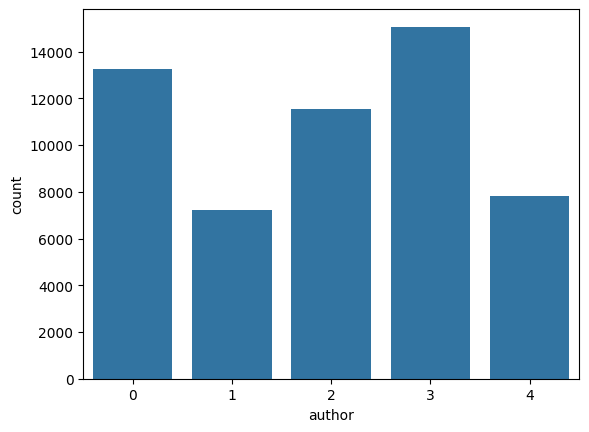

In [ ]:
# 작가 비율
sns.barplot(train['author'].value_counts())

In [ ]:
# 수치형 통계량 확인
train.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
index,54879.0,27439.000,15842.347,0.000,13719.500,27439.000,41158.500,54878.000
author,54879.0,1.945,1.392,0.000,1.000,2.000,3.000,4.000
average_word,54879.0,4.498,0.587,1.000,4.130,4.434,4.780,16.800
unique_word,54879.0,33.147,33.332,1.000,11.000,20.000,42.000,256.000
total_sentence,54879.0,3.461,2.670,1.000,2.000,3.000,4.000,66.000
period_pro,54879.0,0.032,0.018,0.000,0.021,0.028,0.039,0.292
ques_pro,54879.0,0.004,0.009,0.000,0.000,0.000,0.001,0.103
excla_pro,54879.0,0.002,0.007,0.000,0.000,0.000,0.000,0.128
hyp_pro,54879.0,0.002,0.008,0.000,0.000,0.000,0.000,0.205
quot_pro,54879.0,0.026,0.025,0.000,0.003,0.022,0.041,0.214


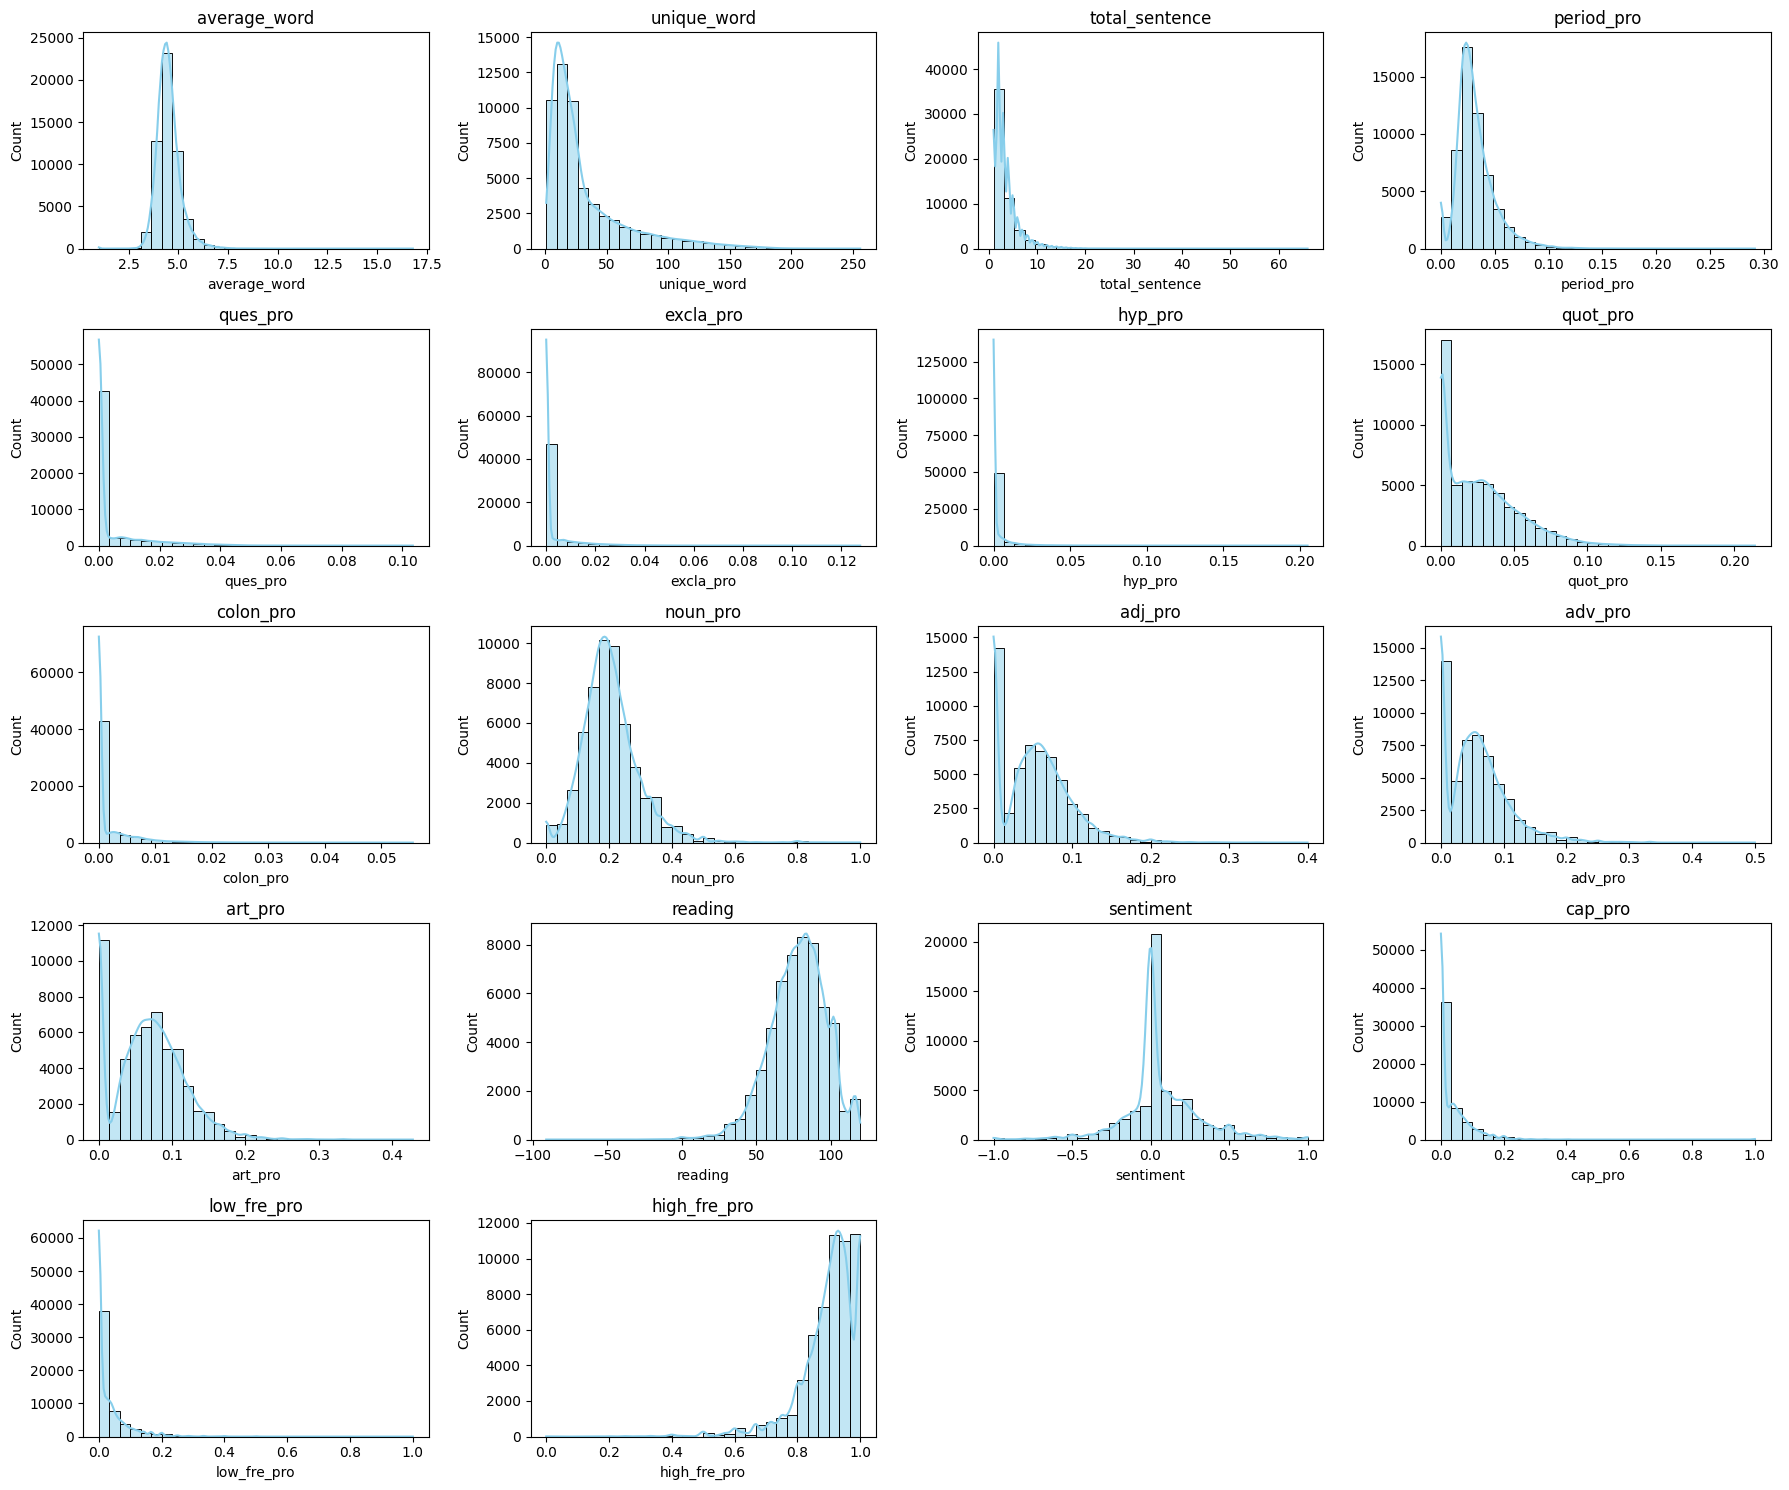

In [ ]:
# 피처별 전체 분포 확인
features = [col for col in train.columns if col not in ['index', 'text', 'author']]
num_cols = len(features)
n_cols = 4
n_rows = (num_cols // n_cols) + 1

plt.figure(figsize=(18, n_rows * 3))
for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(train[col], bins=30, kde=True, color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

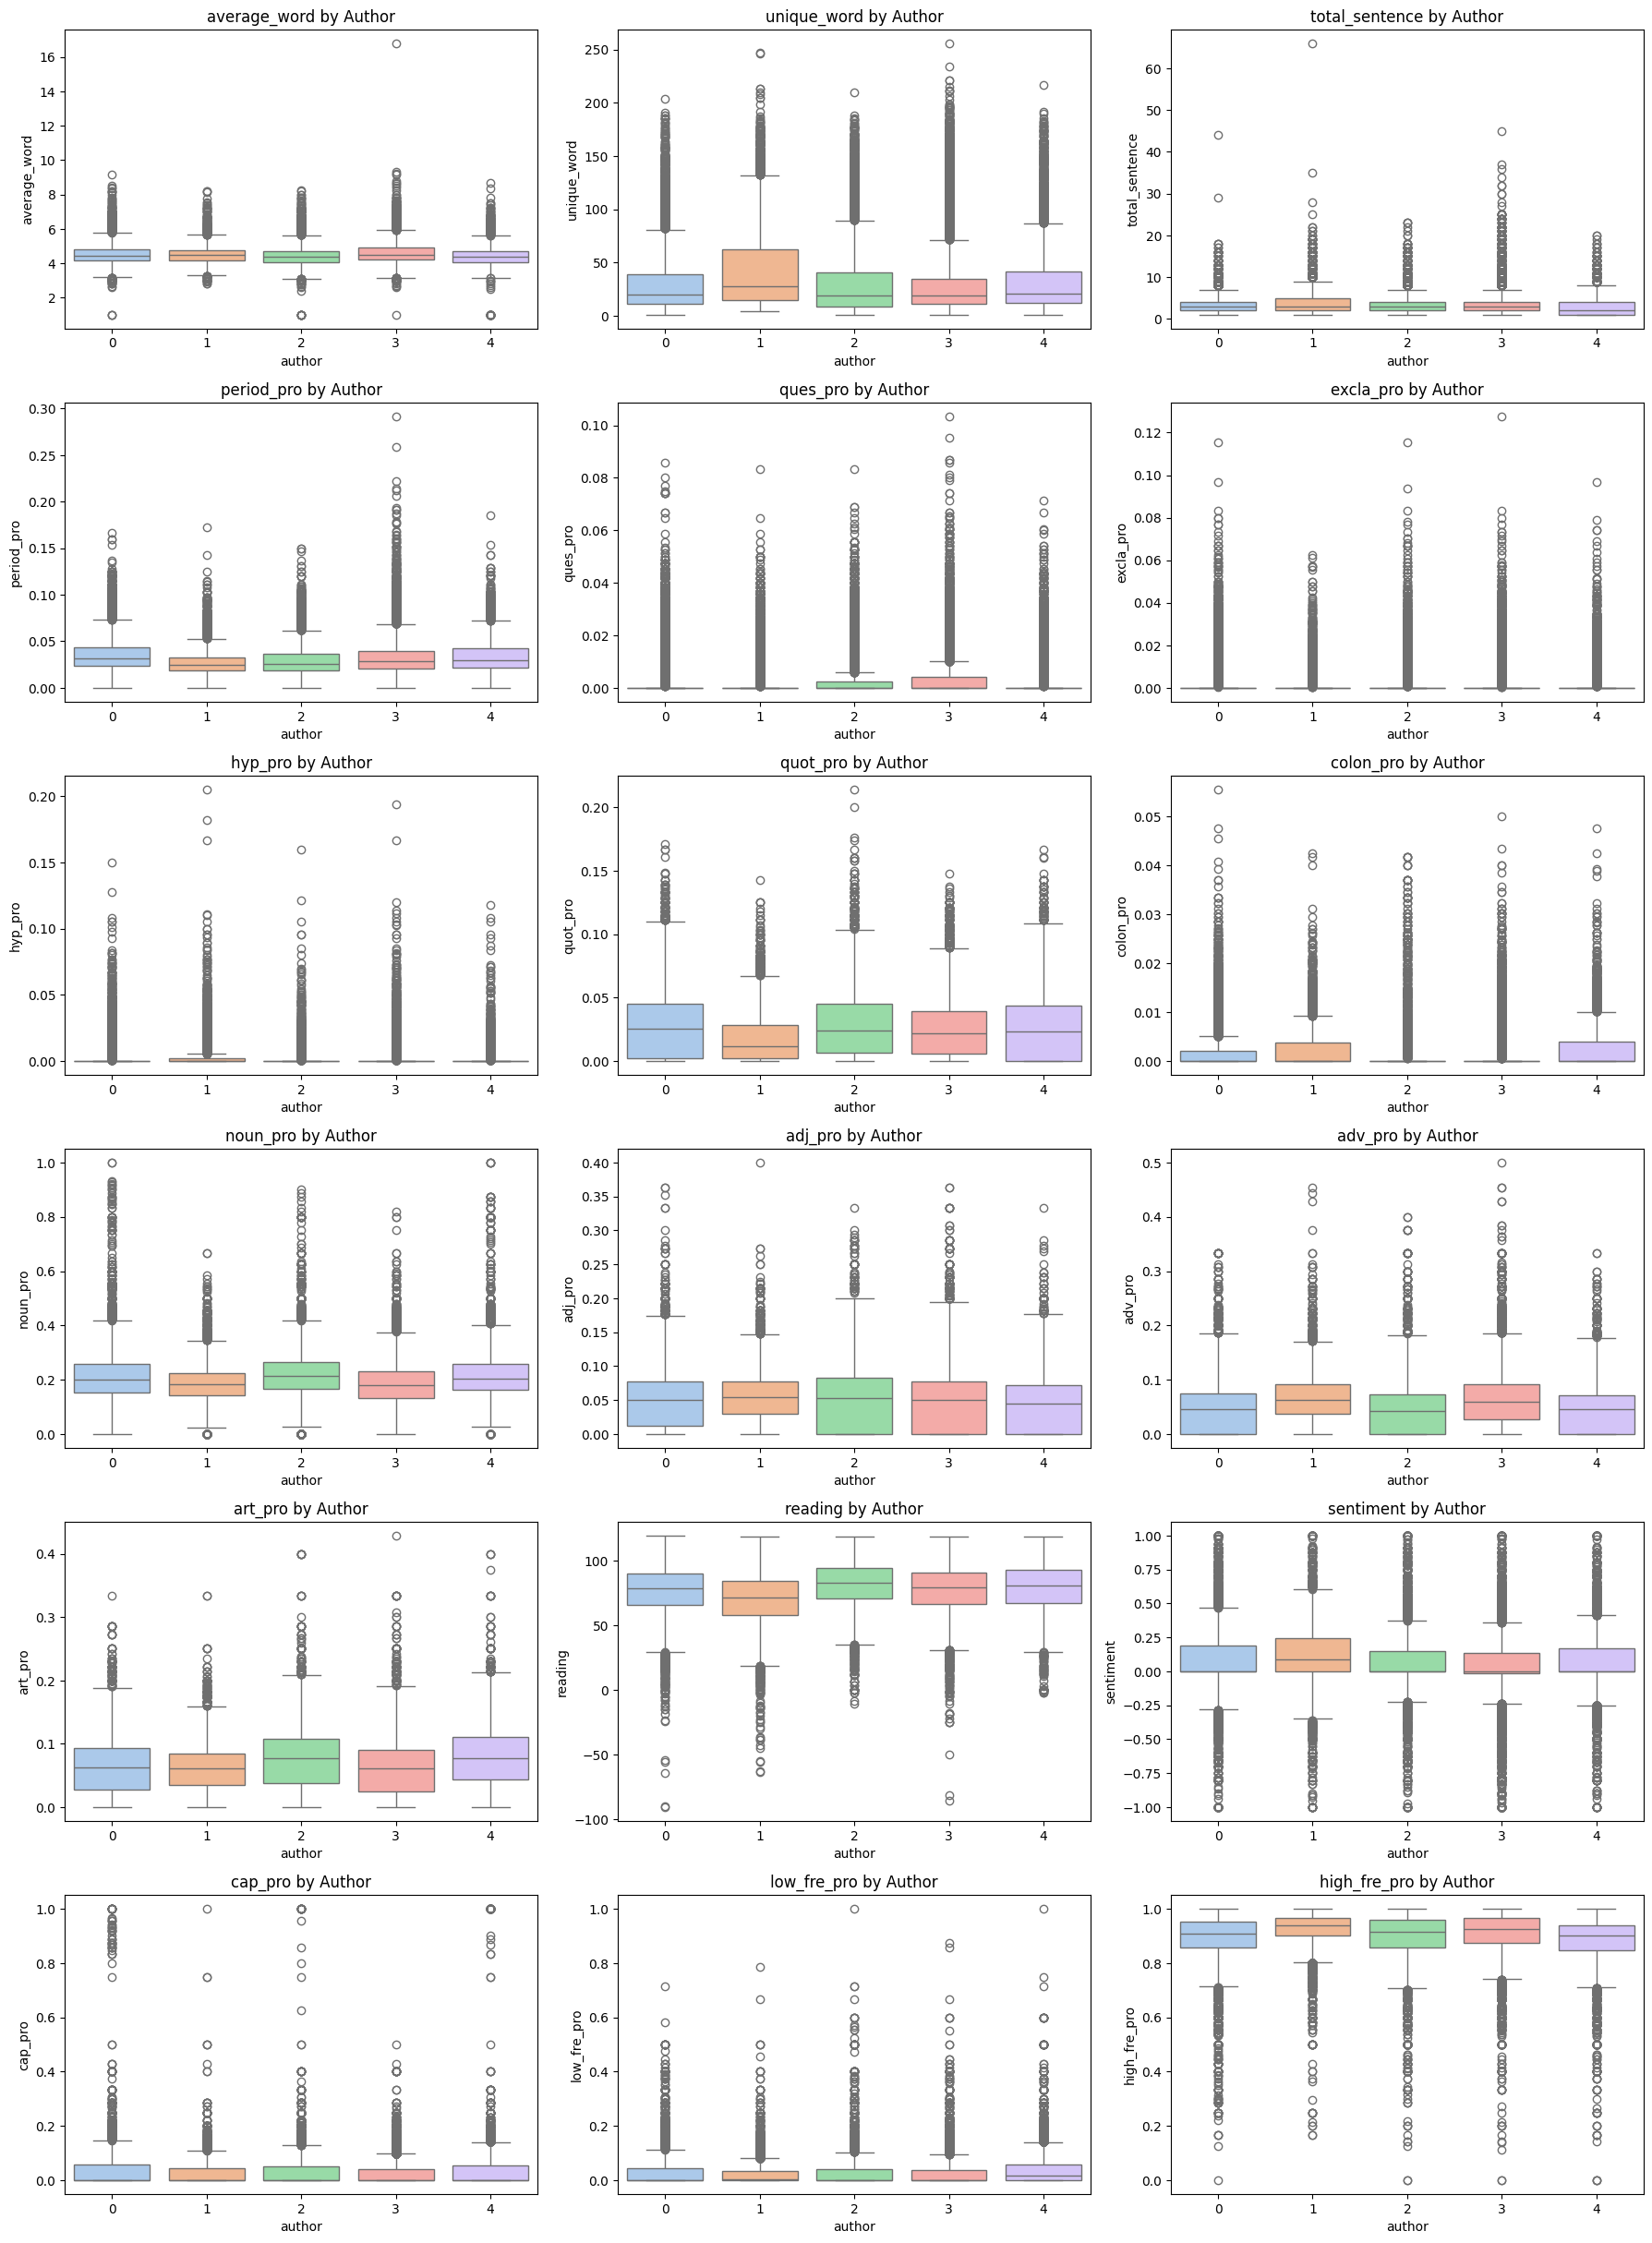

In [ ]:
#작가(author)별 분포 비교
n_cols = 3
n_rows = (num_cols // n_cols) + 1

plt.figure(figsize=(18, n_rows * 4))
for i, col in enumerate(features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=train, x='author', y=col, palette='pastel')
    plt.title(f'{col} by Author')
plt.tight_layout()
plt.show()

In [ ]:
#작가별 평균 비교 테이블
author_means = train.groupby('author')[features].mean().round(3)
author_means.T.sort_index()

author,0,1,2,3,4
adj_pro,0.052,0.055,0.054,0.053,0.047
adv_pro,0.050,0.067,0.048,0.065,0.048
art_pro,0.063,0.060,0.074,0.062,0.078
average_word,4.510,4.502,4.415,4.589,4.418
cap_pro,0.041,0.027,0.036,0.025,0.041
colon_pro,0.002,0.002,0.001,0.001,0.002
excla_pro,0.003,0.002,0.002,0.003,0.002
high_fre_pro,0.891,0.924,0.897,0.909,0.880
hyp_pro,0.003,0.004,0.002,0.002,0.002
low_fre_pro,0.033,0.025,0.032,0.028,0.041


# 4. 추가 전처리

In [14]:
# 영어 불용어 설정
english_stopwords = set(stopwords.words('english'))

def preprocess_text(text):
    # 1. 대소문자 차이 제거: 모두 소문자로 변환 (text.lower())
    text = text.lower()

    # 2. 특수문자 및 숫자 정리: 알파벳과 공백을 제외한 모든 문자 제거
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 3. 토큰화 및 불용어 제거
    words = word_tokenize(text)

    # 불용어가 아니거나 길이가 1보다 긴 단어만 선택 (불필요한 공백/단일 문자 제거)
    filtered_words = [word for word in words if word not in english_stopwords and len(word) > 1]

    # 처리된 단어들을 다시 하나의 문자열로 결합
    return ' '.join(filtered_words)

train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

# 5. 피처 벡터화

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# CountVectorizer 설정
count_vec = CountVectorizer(
    ngram_range=(1, 3),
    min_df=50,                  # 최소 50개 문서에 등장한 n-gram만 사용
    max_features=10000          # 최대 10,000개 특징
)

# 1. 훈련 데이터에 fit_transform 적용
train_count = count_vec.fit_transform(train['text'].values)

# 2. 테스트 데이터에 transform 적용
test_count = count_vec.transform(test['text'].values)

# 결과 확인
print(f"Train CountVectorizer 행렬 크기: {train_count.shape}")
print(f"Test CountVectorizer 행렬 크기: {test_count.shape}")

Train CountVectorizer 행렬 크기: (54879, 3397)
Test CountVectorizer 행렬 크기: (19617, 3397)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# TF-IDF Vectorizer 설정
tfidf_vec = TfidfVectorizer(
    ngram_range=(1, 3),         # 단어 1개~3개 묶음(unigram, bigram, trigram)을 특징으로 사용
    min_df=50,                  # 전체 문서 중 최소 50개 문서 이상에서 등장한 단어만 특징으로 사용
    max_features=10000          # 최대 특징(컬럼) 개수를 10,000개로 제한 (선택 사항, 모델 학습 속도 조절용)
)

# 1. 훈련 데이터에 fit_transform 적용
# TF-IDF 모델을 train 데이터로 학습(fit)하고 변환(transform)합니다.
train_tfidf = tfidf_vec.fit_transform(train['text'].values)

# 2. 테스트 데이터에 transform 적용
# 반드시 훈련 데이터로 학습된(fit) 모델을 그대로 사용하여 변환(transform)해야 합니다.
test_tfidf = tfidf_vec.transform(test['text'].values)

# 결과 확인
print(f"Train TF-IDF 행렬 크기: {train_tfidf.shape}")
print(f"Test TF-IDF 행렬 크기: {test_tfidf.shape}")

Train TF-IDF 행렬 크기: (54879, 3397)
Test TF-IDF 행렬 크기: (19617, 3397)


# 6. CountVectorizer 단일 모델

## 1) 피처 스케일링 진행

In [16]:
from sklearn.preprocessing import StandardScaler

# 스케일링 대상 컬럼만 추출
num_cols = [ 'average_word', 'unique_word',
       'total_sentence', 'period_pro', 'ques_pro', 'excla_pro', 'hyp_pro',
       'quot_pro', 'colon_pro', 'noun_pro', 'adj_pro', 'adv_pro', 'art_pro',
       'reading', 'sentiment', 'cap_pro', 'low_fre_pro', 'high_fre_pro'
]

scaler = StandardScaler()

# 학습 데이터에 fit + transform
train[num_cols] = scaler.fit_transform(train[num_cols])

# 2. 테스트 데이터에 transform만 적용
test[num_cols] = scaler.transform(test[num_cols])

In [17]:
from scipy.sparse import hstack, csr_matrix

# 3. 수치형 → sparse로 변환
X_train_num_sparse = csr_matrix(train[num_cols].values)
X_test_num_sparse = csr_matrix(test[num_cols].values)

# 4. 텍스트 + 수치형 결합
X_train_combined = hstack([train_count, X_train_num_sparse])
X_test_combined = hstack([test_count, X_test_num_sparse])

y_train=train['author']

## 2) 모델링

### 2-1. Logistic Regression

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import numpy as np

# 1. 모델 정의
clf = LogisticRegression(max_iter=1000,random_state=42)

# 2. 교차검증 실행
scores = cross_val_score(clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')

logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 0.8398
각 Fold 점수: [0.8450021  0.84409069 0.83025131]


### 2-2. SGDClassifier

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
import numpy as np

# 1. 모델 정의
sgd_clf = SGDClassifier(loss='log_loss',random_state=42)

# 2. 교차 검증
scores = cross_val_score(sgd_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 0.8477
각 Fold 점수: [0.8465478  0.85871867 0.83779635]


### 2-3. SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. 모델 정의
svc_clf = SVC(random_state=42, probability=True)

# 2. 교차 검증
scores = cross_val_score(svc_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

NameError: name 'X_train_combined' is not defined

### 2-4. Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
import numpy as np

# 1. 모델 정의
dt_clf = DecisionTreeClassifier(random_state=42)

# 2. 교차 검증
scores = cross_val_score(dt_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 20.2474
각 Fold 점수: [20.27934239 20.3428148  20.12014921]


### 2-5. RandomForest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
import numpy as np

# 1. 모델 정의
rf_clf = RandomForestClassifier(random_state=42)

# 2. 교차 검증
scores = cross_val_score(rf_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 1.1186
각 Fold 점수: [1.11745383 1.12100721 1.11741385]


### 2-6. LightGBM

In [21]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
import numpy as np

# 1. 모델 정의
lg_clf = LGBMClassifier(random_state=42)

# 2. 교차 검증
scores = cross_val_score(lg_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.804777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14954
[LightGBM] [Info] Number of data points in the train set: 36586, number of used features: 3415
[LightGBM] [Info] Start training from score -1.422190
[LightGBM] [Info] Start training from score -2.027930
[LightGBM] [Info] Start training from score -1.558186
[LightGBM] [Info] Start training from score -1.292889
[LightGBM] [Info] Start training from score -1.950430
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.803160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14961
[LightGBM] [Info] Number of data points in the train set: 36586, number of used features: 3415
[LightGBM] [Info] 

### 2-7. XGBoost

In [23]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
import numpy as np

# 1. 모델 정의
xgb_clf = XGBClassifier(random_state=42)

# 2. 교차 검증
scores = cross_val_score(xgb_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 0.9084
각 Fold 점수: [0.91316712 0.90769849 0.90430558]


### 2-8. CatBoost

In [25]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


In [26]:
from catboost import CatBoostClassifier

# 1. 모델 정의
cat_clf = CatBoostClassifier(random_state=42,verbose=0)

# 2. 교차 검증
scores = cross_val_score(cat_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 0.8838
각 Fold 점수: [0.88346327 0.88699632 0.88086799]


### 2-9. Gaussian Bayes

In [27]:
from sklearn.naive_bayes import GaussianNB

nb_clf = GaussianNB()
scores = cross_val_score(nb_clf, X_train_combined.toarray(), y_train, cv=5, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 17.7344
각 Fold 점수: [17.80545809 18.07285222 17.53628226 17.78393609 17.47327869]


### 2-10. KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier

# 1. 모델 정의
knn_clf = KNeighborsClassifier()

# 2. 교차 검증
scores = cross_val_score(knn_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 8.1550
각 Fold 점수: [8.2053213  8.14323646 8.11656532]


### 2-11. MLPClassifier

In [29]:
from sklearn.neural_network import MLPClassifier

# 1. 모델 정의
mlp_clf = MLPClassifier(random_state=42)


# 2. 교차 검증
scores = cross_val_score(mlp_clf, X_train_combined, y_train, cv=3, scoring='neg_log_loss')
logloss_scores = -scores

# 3. 결과 출력
print(f"평균 정확도: {np.mean(logloss_scores ):.4f}")
print(f"각 Fold 점수: {logloss_scores}")

평균 정확도: 2.9182
각 Fold 점수: [2.81298864 2.91829633 3.02344964]


| Model               | Log Loss  |
|----------------------|-----------|
| Logistic Regression  | 0.8399    |
| SGDClassifier        | 0.8477    |
| SVM                  | —         |
| Decision Tree        | 20.2474   |
| Random Forest        | 1.1186    |
| LightGBM             | 0.8414    |
| XGBoost              | 0.9084    |
| CatBoost             | 0.8838    |
| GaussianNB           | 17.7344   |
| KNN                  | 8.1550    |
| MLPClassifier        | 2.9547    |

-> 상위 3개 모델: Logistic Regression, SGDClassifier, LightGBM

## 3. GridSearchCV

상위 3개 모델: Logistic Regression, SGDClassifier, LightGBM에 적용

### 3-1. Logistic Regression

In [ ]:
# 1. 모델 정의
clf = LogisticRegression(max_iter=1000,random_state=42)

# 2. 파라미터 그리드 설정
lr_param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'max_iter' : [500,1000,1500]
}

# 3. GridSearchCV 설정
lr_grid = GridSearchCV(
    clf,
    lr_param_grid,
    scoring='neg_log_loss',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 4. 학습
lr_grid.fit(X_train_combined, y_train)

# 5. 결과 확인
print("최적 파라미터:", lr_grid.best_params_)
print("최소 log loss (평균):", -lr_grid.best_score_)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
최적 파라미터: {'C': 1, 'max_iter': 500}
최소 log loss (평균): 0.8398311127572465


### 3-2. SGDClassifier

In [ ]:
# 1. 모델 정의
sgd_clf = SGDClassifier(loss='log_loss',random_state=42)

# 2. 파라미터 그리드 설정
sgd_param_grid = {
    'alpha': [0.0001, 0.001,0.01,],
    'penalty': ['l2', 'elasticnet'],
    'max_iter': [1000,1500],
    'eta0': [0.01, 0.1]             # 학습률 초기값
}

# 3. GridSearchCV 설정
sgd_grid = GridSearchCV(
    sgd_clf,
    sgd_param_grid,
    scoring='neg_log_loss',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 4. 학습
sgd_grid.fit(X_train_combined, y_train)

# 5. 결과 확인
print("최적 파라미터:", sgd_grid.best_params_)
print("최소 log loss (평균):", -sgd_grid.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
최적 파라미터: {'alpha': 0.0001, 'eta0': 0.01, 'max_iter': 1000, 'penalty': 'elasticnet'}
최소 log loss (평균): 0.8472200829194373


### 3-3. LightGBM

In [ ]:
from lightgbm import LGBMClassifier
# 1. 모델 정의
lg_clf = LGBMClassifier(random_state=42)

# 2. 파라미터 그리드 설정
lg_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [10, 20, 30]
}

# 3. GridSearchCV 설정
lg_grid = GridSearchCV(
    lg_clf,
    lg_param_grid,
    scoring='neg_log_loss',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 4. 학습
lg_grid.fit(X_train_combined, y_train)

# 5. 결과 확인
print("최적 파라미터:", lg_grid.best_params_)
print("최소 log loss (평균):", -lg_grid.best_score_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.987193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15569
[LightGBM] [Info] Number of data points in the train set: 54879, number of used features: 3415
[LightGBM] [Info] Start training from score -1.422266
[LightGBM] [Info] Start training from score -2.027999
[LightGBM] [Info] Start training from score -1.558099
[LightGBM] [Info] Start training from score -1.292889
[LightGBM] [Info] Start training from score -1.950366
최적 파라미터: {'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'n_estimators': 300}
최소 log loss (평균): 0.7995017463542279


## 4. 최종

(1) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42,C=1,max_iter=500)
clf.fit(X_train_combined, y_train)
y_pred_lr=clf.predict(X_test_combined)

file_path='/content/drive/MyDrive/sample_submission.csv'
counting_submission_1 = pd.read_csv(file_path)

for i, pred in enumerate(y_pred_lr):
    counting_submission_1.iloc[i, pred + 1] = 1

# 결과 확인
print(counting_submission_1.head())

public 점수 : 6.9307811299

private 점수 : 6.7990998084

(2) SGDClassifier

In [ ]:
sgd_clf = SGDClassifier(loss='log_loss',random_state=42,alpha= 0.0001, eta0= 0.01, max_iter= 1000, penalty='elasticnet')

sgd_clf.fit(X_train_combined, y_train)
y_pred_sgd=sgd_clf.predict(X_test_combined)

counting_submission_2 = pd.read_csv(file_path)

for i, pred in enumerate(y_pred_sgd):
    counting_submission_2.iloc[i, pred + 1] = 1

# 결과 확인
print(counting_submission_2.head())

public 점수 : 6.9307811299

private 점수 : 6.7990998084

(3) LightGBM

In [ ]:
from lightgbm import LGBMClassifier
lg_clf = LGBMClassifier(random_state=42, learning_rate=0.05, max_depth= -1, min_child_samples=20, n_estimators= 300)

lg_clf.fit(X_train_combined, y_train)
y_pred_lg=lg_clf.predict(X_test_combined)

counting_submission_3 = pd.read_csv(file_path)

for i, pred in enumerate(y_pred_lg):
    counting_submission_3.iloc[i, pred + 1] = 1

# 결과 확인
print(counting_submission_3.head())

public 점수 : 6.4625888277

private 점수 : 6.3501640315

## 5. 스태킹 적용

[Version.1]
1. Base 모델
- Logistic Regression (clf)
- SGDClassifier (sgd_clf)
- LightGBM (lg_clf)

2. Meta 모델
- Logistic Regressio (clf)

In [37]:
# Base Models 정의
clf = LogisticRegression(max_iter=2000, n_jobs=-1)
sgd_clf = SGDClassifier(loss='log_loss')
lg_clf = LGBMClassifier(
    objective='multiclass',
    num_class=5,
    learning_rate=0.05,
    n_estimators=500,
    max_depth=7,
    n_jobs=-1
)

In [40]:
# OOF 스태킹 함수
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

def run_oof_single(model, name, X, y, X_test):
    print(f"\n[{name}] Start OOF")

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_train = np.zeros((X.shape[0], 5))
    oof_test = np.zeros((X_test.shape[0], 5))
    test_folds = np.zeros((5, X_test.shape[0], 5))

    scores = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X, y)):
        tr_X, val_X = X[tr_idx], X[val_idx]
        tr_y, val_y = y[tr_idx], y[val_idx]

        model.fit(tr_X, tr_y)

        pred_val = model.predict_proba(val_X)
        pred_test = model.predict_proba(X_test)

        oof_train[val_idx] = pred_val
        test_folds[fold] = pred_test

        score = log_loss(val_y, pred_val)
        scores.append(score)
        print(f" - Fold {fold} LogLoss: {score:.5f}")

    oof_test[:] = test_folds.mean(axis=0)
    print(f"[{name}] Mean CV: {np.mean(scores):.5f}")

    # 저장 (train / test는 너가 이미 사용하는 DataFrame일 것 → 그대로 갱신)
    for i in range(5):
        train[f"{name}_{i}"] = oof_train[:, i]
        test[f"{name}_{i}"] = oof_test[:, i]

In [41]:
# Base 모델 3개 OOF 생성
run_oof_single(clf, "stack_LR", X_train_combined, y_train, X_test_combined)
run_oof_single(sgd_clf, "stack_SGD", X_train_combined, y_train, X_test_combined)
run_oof_single(lg_clf, "stack_LGBM", X_train_combined, y_train, X_test_combined)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [42]:
# Meta 모델 학습
meta_features = [col for col in train.columns if col.startswith("stack_")]

X_meta = train[meta_features]
y_meta = y_train

meta_model = LogisticRegression(max_iter=3000, n_jobs=-1)
meta_model.fit(X_meta, y_meta)

test_meta = test[meta_features]
test_pred = meta_model.predict_proba(test_meta)

In [47]:
# 최종 제출 csv 생성 코드
import pandas as pd

submission = pd.DataFrame({
    "id": test.index   # id 없을 때 가장 안전한 방식
})

for i in range(5):
    submission[str(i)] = test_pred[:, i]

submission.to_csv("submission.csv", index=False)

print("submission.csv 생성 완료")
submission.head()

submission.csv 생성 완료


,id,0,1,2,3,4
0,0,0.026630,0.923853,0.031122,0.013564,0.004830
1,1,0.497457,0.255571,0.052619,0.041869,0.152484
2,2,0.980558,0.003659,0.003339,0.002835,0.009609
3,3,0.006057,0.009354,0.967317,0.007299,0.009973
4,4,0.502798,0.071925,0.123123,0.115157,0.186996


[Version.2]

1. Base 모델
- Logistic Regression
- SGDClassifier
- LightGBM
- CatBoost

2. Meta 모델
- Logistic Regression

In [48]:
run_oof_single(clf, "stack_LR", X_train_combined, y_train, X_test_combined)
run_oof_single(sgd_clf, "stack_SGD", X_train_combined, y_train, X_test_combined)
run_oof_single(lg_clf, "stack_LGBM", X_train_combined, y_train, X_test_combined)
run_oof_single(cat_clf, "stack_CAT", X_train_combined, y_train, X_test_combined)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [49]:
# Meta 모델 학습
from sklearn.linear_model import LogisticRegression

meta_features = [
    col for col in train.columns
    if col.startswith("stack_LR")
    or col.startswith("stack_SGD")
    or col.startswith("stack_LGBM")
    or col.startswith("stack_CAT")
]

X_meta = train[meta_features]
y_meta = y_train

# Meta model 학습
meta_model = LogisticRegression(max_iter=3000, n_jobs=-1)
meta_model.fit(X_meta, y_meta)

# Test 메타 피처 준비
test_meta = test[meta_features]

# 최종 예측 확률
test_pred = meta_model.predict_proba(test_meta)

In [50]:
import pandas as pd
import numpy as np

# 제출용 데이터프레임 생성
submission = pd.DataFrame({
    "id": test.index   # id 없을 때 가장 안전한 방식
})

# 클래스 0~4 확률 입력
for i in range(5):
    submission[str(i)] = test_pred[:, i]

# CSV 저장
submission.to_csv("submission_version2.csv", index=False)

print("Version.2 제출 파일 생성 완료: submission_version2.csv")
submission.head()

Version.2 제출 파일 생성 완료: submission_version2.csv


,id,0,1,2,3,4
0,0,0.034834,0.911360,0.035189,0.013031,0.005586
1,1,0.526899,0.243812,0.053281,0.036339,0.139669
2,2,0.980479,0.003766,0.003453,0.002937,0.009366
3,3,0.006234,0.009857,0.964693,0.008247,0.010969
4,4,0.486074,0.080944,0.156471,0.111733,0.164777


In [52]:
# 스태킹 모델 최종 log loss 출력
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import numpy as np

def compute_meta_logloss(prefix_list):
    """
    주어진 prefix들(stack_LR, stack_SGD, ...)을 메타 입력으로 사용해서
    메타 LogisticRegression을 OOF 방식으로 돌리고 최종 LogLoss 반환
    """
    # 1) 메타 입력 피처 만들기
    cols = []
    for pre in prefix_list:
        cols += [f"{pre}_{i}" for i in range(5)]
    X_meta = train[cols].values
    y = np.array(y_train)   # 혹시 Series여도 배열로

    # 2) 메타 모델 OOF 예측
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oof_meta = np.zeros((X_meta.shape[0], 5))

    for tr_idx, val_idx in kf.split(X_meta, y):
        X_tr, X_val = X_meta[tr_idx], X_meta[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        meta_model = LogisticRegression(max_iter=3000, n_jobs=-1)
        meta_model.fit(X_tr, y_tr)

        oof_meta[val_idx] = meta_model.predict_proba(X_val)

    # 3) 최종 LogLoss
    score = log_loss(y, oof_meta)
    return score


# Version A: Base 3개 (LR, SGD, LGBM)
versionA_prefix = ["stack_LR", "stack_SGD", "stack_LGBM"]

# Version B: Base 4개 (LR, SGD, LGBM, CAT)
versionB_prefix = ["stack_LR", "stack_SGD", "stack_LGBM", "stack_CAT"]

logloss_A = compute_meta_logloss(versionA_prefix)
logloss_B = compute_meta_logloss(versionB_prefix)

print("===== FINAL META LOG LOSS =====")
print(f"Version A (Base 3: LR + SGD + LGBM) LogLoss : {logloss_A:.5f}")
print(f"Version B (Base 4: LR + SGD + LGBM + CAT) LogLoss : {logloss_B:.5f}")

===== FINAL META LOG LOSS =====
Version A (Base 3: LR + SGD + LGBM) LogLoss : 0.75549
Version B (Base 4: LR + SGD + LGBM + CAT) LogLoss : 0.75050


# 7. TF-IDF 단일 모델

## 1) 피처 스케일링 진행

In [ ]:
import numpy as np
from scipy.sparse import hstack, csr_matrix

# 1. 텍스트 TF-IDF (이미 만든 거 그대로 사용)
X_text_train = train_tfidf          # shape: (n_train, d_text)
X_text_test  = test_tfidf           # shape: (n_test,  d_text)

# 2. 스케일링 끝난 수치형 피처 행렬로 꺼내기
num_cols = [ 'average_word', 'unique_word',
       'total_sentence', 'period_pro', 'ques_pro', 'excla_pro', 'hyp_pro',
       'quot_pro', 'colon_pro', 'noun_pro', 'adj_pro', 'adv_pro', 'art_pro',
       'reading', 'sentiment', 'cap_pro', 'low_fre_pro', 'high_fre_pro'
]

X_num_train = train[num_cols].values   # 이미 StandardScaler 적용된 값
X_num_test  = test[num_cols].values

# 3. TF-IDF(희소) + 수치형(조밀)을 함께 희소로 만들어서 hstack
X_train = hstack([X_text_train, csr_matrix(X_num_train)])
X_test  = hstack([X_text_test,  csr_matrix(X_num_test)])

y_train = train['author'].values

print(X_train.shape, X_test.shape)

(54879, 3415) (19617, 3415)


## 2) 모델링

### 2-1. Logistic Regression (채택)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    max_iter=2000,
    solver='liblinear',   # 데이터 크기에 무난
    C=1.0,
    multi_class='ovr'
)

clf.fit(X_train, y_train)
proba = clf.predict_proba(X_test)   # (n_test, 5)

In [ ]:
import pandas as pd

submission = pd.DataFrame(proba, columns=['0','1','2','3','4'])
submission.insert(0, 'index', test['index'])
submission.to_csv('submission_tfidf_num_lr.csv', index=False)
print("✅ submission_tfidf_num_lr.csv 저장 완료")

✅ submission_tfidf_num_lr.csv 저장 완료


In [ ]:
from sklearn.metrics import accuracy_score, log_loss

train_pred = clf.predict(X_train)
train_proba = clf.predict_proba(X_train)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Train LogLoss:", log_loss(y_train, train_proba))

Train Accuracy: 0.7409391570546111
Train LogLoss: 0.7769371284050698


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

clf2 = LogisticRegression(
    max_iter=2000, solver='liblinear', C=1.0, multi_class='ovr'
)
clf2.fit(X_tr, y_tr)

val_proba = clf2.predict_proba(X_val)
print("Validation LogLoss:", log_loss(y_val, val_proba))


Validation LogLoss: 0.8675235616412754


**Public: 6580891322**

**Private: 0.6560082072**

### 2-2. Random Forest

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack, csr_matrix

X_text_train = train_tfidf
X_text_test  = test_tfidf

X_num_train = train[num_cols].values   # 이미 스케일링된 값
X_num_test  = test[num_cols].values

X_train_all = hstack([X_text_train, csr_matrix(X_num_train)])
X_test_all  = hstack([X_text_test,  csr_matrix(X_num_test)])

y_train = train['author'].values

def save_submission(proba, filename):
    sub = pd.DataFrame(proba, columns=['0','1','2','3','4'])
    sub.insert(0, 'index', test['index'])
    sub.to_csv(filename, index=False)
    print("Saved:", filename)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_all, y_train)
proba_rf = rf.predict_proba(X_test_all)
save_submission(proba_rf, 'sub_randomforest.csv')

Saved: sub_randomforest.csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.ensemble import RandomForestClassifier

# TF-IDF + 수치형 합친 전체 feature
# (네가 이미 만든 X_train_all 그대로 사용)
X = X_train_all
y = y_train

# 1) train/valid split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2) RF 모델 정의 (너가 썼던 설정 그대로)
rf_val = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

# 3) 학습
rf_val.fit(X_tr, y_tr)

# 4) 예측 확률
val_proba = rf_val.predict_proba(X_val)

# 5) logloss 계산
rf_logloss = log_loss(y_val, val_proba)
print("🔹 RF Validation LogLoss:", rf_logloss)

# 6) accuracy 계산
val_pred = rf_val.predict(X_val)
rf_acc = accuracy_score(y_val, val_pred)
print("🔹 RF Validation Accuracy:", rf_acc)

🔹 RF Validation LogLoss: 1.1140037723027902
🔹 RF Validation Accuracy: 0.615615889212828


### 2-3. LightGBM

In [ ]:
import lightgbm as lgb
import numpy as np

X_train_num = train[num_cols].values
X_test_num  = test[num_cols].values
y_train = train['author'].values

lgb_num = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_num.fit(X_train_num, y_train)
proba_lgb_num = lgb_num.predict_proba(X_test_num)
save_submission(proba_lgb_num, 'sub_lightgbm_numeric_only.csv')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4288
[LightGBM] [Info] Number of data points in the train set: 54879, number of used features: 18
[LightGBM] [Info] Start training from score -1.422266
[LightGBM] [Info] Start training from score -2.027999
[LightGBM] [Info] Start training from score -1.558099
[LightGBM] [Info] Start training from score -1.292889
[LightGBM] [Info] Start training from score -1.950366
Saved: sub_lightgbm_numeric_only.csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import lightgbm as lgb

# 1. 데이터 준비
X = X_train_num
y = y_train

# 2. train / validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3. LightGBM 모델 (너가 쓴 것 동일)
lgb_val = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# 4. 학습
lgb_val.fit(X_tr, y_tr)

# 5. 예측 확률
val_proba = lgb_val.predict_proba(X_val)

# 6. LogLoss
val_logloss = log_loss(y_val, val_proba)
print("🔹 LightGBM (numeric only) Validation LogLoss:", val_logloss)

# 7. Accuracy
val_pred = lgb_val.predict(X_val)
val_acc = accuracy_score(y_val, val_pred)
print("🔹 LightGBM (numeric only) Validation Accuracy:", val_acc)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4280
[LightGBM] [Info] Number of data points in the train set: 43903, number of used features: 18
[LightGBM] [Info] Start training from score -1.422261
[LightGBM] [Info] Start training from score -2.027925
[LightGBM] [Info] Start training from score -1.558116
[LightGBM] [Info] Start training from score -1.292918
[LightGBM] [Info] Start training from score -1.950362
🔹 LightGBM (numeric only) Validation LogLoss: 1.2425965321273942
🔹 LightGBM (numeric only) Validation Accuracy: 0.48770043731778423


### 2-4. XGBoost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from xgboost import XGBClassifier

X = X_train_num
y = y_train

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

xgb_val = XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42
)

xgb_val.fit(X_tr, y_tr)
val_proba = xgb_val.predict_proba(X_val)

print("XGBoost (numeric only) val logloss:", log_loss(y_val, val_proba))

val_pred = xgb_val.predict(X_val)
print("XGBoost (numeric only) val accuracy:", accuracy_score(y_val, val_pred))

XGBoost (numeric only) val logloss: 1.2359202652954124
XGBoost (numeric only) val accuracy: 0.4873360058309038


Naive Bayes (MultinomialNB)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# y 라벨
y_train = train['author'].values

# 1) 모델 정의
nb = MultinomialNB(alpha=0.5)   # alpha는 스무딩, 0.5~1.0 많이 씀

# 2) 학습 (TF-IDF만 사용, 수치형 안 씀!)
nb.fit(train_tfidf, y_train)

# 3) 테스트 예측 (확률)
proba_nb = nb.predict_proba(test_tfidf)

# 4) 제출 파일 저장
save_submission(proba_nb, 'sub_multinb_tfidf_only.csv')

Saved: sub_multinb_tfidf_only.csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.naive_bayes import MultinomialNB

X = train_tfidf
y = y_train

# 1) train/valid 나누기
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2) 모델
nb_val = MultinomialNB(alpha=0.5)

# 3) 학습
nb_val.fit(X_tr, y_tr)

# 4) validation 예측
val_proba = nb_val.predict_proba(X_val)
val_pred  = nb_val.predict(X_val)

# 5) 점수 출력
print("🔹 NB Validation LogLoss:", log_loss(y_val, val_proba))
print("🔹 NB Validation Accuracy:", accuracy_score(y_val, val_pred))

🔹 NB Validation LogLoss: 0.9500490827645771
🔹 NB Validation Accuracy: 0.6645408163265306


### 2-5. KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train_num = train[num_cols].values   # 이미 StandardScaler로 스케일링된 상태
X_test_num  = test[num_cols].values
y_train = train['author'].values

knn_num = KNeighborsClassifier(
    n_neighbors=5,          # 3이나 7로 바꿔가며 비교해봐도 됨
    metric='minkowski',     # 기본 = 유클리드 거리
    n_jobs=-1
)

knn_num.fit(X_train_num, y_train)
proba_knn_num = knn_num.predict_proba(X_test_num)
save_submission(proba_knn_num, 'sub_knn_numeric_only.csv')

Saved: sub_knn_numeric_only.csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# 같은 데이터
X = train[num_cols].values     # 수치형 18개
y = train['author'].values

# 1) train / validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2) 네가 쓴 것과 같은 모델
knn_val = KNeighborsClassifier(
    n_neighbors=5,
    metric='minkowski',
    n_jobs=-1
)

# 3) 학습
knn_val.fit(X_tr, y_tr)

# 4) validation 예측
val_proba = knn_val.predict_proba(X_val)
val_pred  = knn_val.predict(X_val)

# 5) 점수 출력
print("🔹 KNN numeric-only Validation LogLoss:", log_loss(y_val, val_proba))
print("🔹 KNN numeric-only Validation Accuracy:", accuracy_score(y_val, val_pred))


🔹 KNN numeric-only Validation LogLoss: 10.84576108774791
🔹 KNN numeric-only Validation Accuracy: 0.28033892128279886


### 2-6. Neural Network (MLP 등)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=10,          # 처음엔 작게 돌려보고, 나중에 20~30으로 늘려
    random_state=42,
    verbose=True
)

mlp.fit(X_train_all, y_train)
proba_mlp = mlp.predict_proba(X_test_all)
save_submission(proba_mlp, 'sub_mlp.csv')

Iteration 1, loss = 1.41805744
Iteration 2, loss = 0.93025305
Iteration 3, loss = 0.76966840
Iteration 4, loss = 0.71114959
Iteration 5, loss = 0.68102057
Iteration 6, loss = 0.64072217
Iteration 7, loss = 0.62334928
Iteration 8, loss = 0.60353964
Iteration 9, loss = 0.57643167
Iteration 10, loss = 0.56022635
Saved: sub_mlp.csv


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from sklearn.neural_network import MLPClassifier

X = X_train_all
y = y_train

# 1) train / valid 분리
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 2) MLP 모델 (위랑 같은 구조)
mlp_val = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=20,
    random_state=42,
    verbose=True
)

# 3) 학습
mlp_val.fit(X_tr, y_tr)

# 4) validation 예측
val_proba = mlp_val.predict_proba(X_val)
val_pred  = mlp_val.predict(X_val)

# 5) 점수
print("🔹 MLP Validation LogLoss:", log_loss(y_val, val_proba))
print("🔹 MLP Validation Accuracy:", accuracy_score(y_val, val_pred))


Iteration 1, loss = 1.47976008
Iteration 2, loss = 1.02412653
Iteration 3, loss = 0.79865506
Iteration 4, loss = 0.72011831
Iteration 5, loss = 0.66864069
Iteration 6, loss = 0.65076299
Iteration 7, loss = 0.61396534
Iteration 8, loss = 0.58571447
Iteration 9, loss = 0.57466796
Iteration 10, loss = 0.55051297
Iteration 11, loss = 0.52768774
Iteration 12, loss = 0.51387829
Iteration 13, loss = 0.49757268
Iteration 14, loss = 0.46680735
Iteration 15, loss = 0.45635893
Iteration 16, loss = 0.43746621
Iteration 17, loss = 0.42094343
Iteration 18, loss = 0.39596114
Iteration 19, loss = 0.38209971
Iteration 20, loss = 0.35855385
🔹 MLP Validation LogLoss: 1.0196936629555078
🔹 MLP Validation Accuracy: 0.6769314868804664


## 8. TF-IDF 스태킹 모델

사용한 Feature

1. Logistic Regression
2. SGD(확률적 경사하강법)
3. RandomForest
4. MLP
5. DecisionTree
6. Naive Bayes
7. LightGBM
8. CatBoost

사용한 Meta Model

1. XGBoost
2. LightGBM

In [ ]:
!pip install catboost

In [ ]:
import numpy as np
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, log_loss
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(ngram_range=(1,3), min_df=50, max_features=10000)
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

cols_to_drop = ['text', 'index', 'author']
train_X = train.drop(columns=cols_to_drop, errors='ignore')
train_y = train['author'].values
test_X = test.drop(columns=['text', 'index'], errors='ignore')

In [ ]:
from sklearn.linear_model import LogisticRegression

def runLR(train_X,train_y,test_X,test_y,test_X2):
    model=LogisticRegression()
    model.fit(train_X,train_y)
    pred_test_y=model.predict_proba(test_X)
    pred_test_y2=model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores=[]

pred_train=np.zeros([train.shape[0],5])
pred_full_test = 0

cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for dev_index, val_index in cv.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runLR(dev_X, dev_y, val_X, val_y,test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["tfidf_LR_0"] = pred_train[:,0]
train["tfidf_LR_1"] = pred_train[:,1]
train["tfidf_LR_2"] = pred_train[:,2]
train["tfidf_LR_3"] = pred_train[:,3]
train["tfidf_LR_4"] = pred_train[:,4]
test["tfidf_LR_0"] = pred_full_test[:,0]
test["tfidf_LR_1"] = pred_full_test[:,1]
test["tfidf_LR_2"] = pred_full_test[:,2]
test["tfidf_LR_3"] = pred_full_test[:,3]
test["tfidf_LR_4"] = pred_full_test[:,4]

Mean cv score :  0.8279559201886435


In [ ]:
from sklearn.linear_model import SGDClassifier

def runSGD(train_X,train_y,test_X,test_y,test_X2):
    model=SGDClassifier(loss='log_loss')
    model.fit(train_X,train_y)
    pred_test_y=model.predict_proba(test_X)
    pred_test_y2=model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores=[]

pred_train=np.zeros([train.shape[0],5])
pred_full_test = 0

cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for dev_index, val_index in cv.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runSGD(dev_X, dev_y, val_X, val_y,test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5

train["tfidf_SGD_0"] = pred_train[:,0]
train["tfidf_SGD_1"] = pred_train[:,1]
train["tfidf_SGD_2"] = pred_train[:,2]
train["tfidf_SGD_3"] = pred_train[:,3]
train["tfidf_SGD_4"] = pred_train[:,4]
test["tfidf_SGD_0"] = pred_full_test[:,0]
test["tfidf_SGD_1"] = pred_full_test[:,1]
test["tfidf_SGD_2"] = pred_full_test[:,2]
test["tfidf_SGD_3"] = pred_full_test[:,3]
test["tfidf_SGD_4"] = pred_full_test[:,4]

Mean cv score :  1.0219615920720275


In [ ]:
from sklearn.ensemble import RandomForestClassifier

def runRF(train_X,train_y,test_X,test_y,test_X2):
    model=RandomForestClassifier()
    model.fit(train_X,train_y)
    pred_test_y=model.predict_proba(test_X)
    pred_test_y2=model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model


cv_scores=[]
cols_to_drop=['text','index']
train_X = train.drop(cols_to_drop+['author'], axis=1)
train_y=train['author']
test_X = test.drop(cols_to_drop, axis=1)

pred_train=np.zeros([train.shape[0],5])
pred_full_test = 0

cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for dev_index, val_index in cv.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runRF(dev_X, dev_y, val_X, val_y,test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["tfidf_RF_0"] = pred_train[:,0]
train["tfidf_RF_1"] = pred_train[:,1]
train["tfidf_RF_2"] = pred_train[:,2]
train["tfidf_RF_3"] = pred_train[:,3]
train["tfidf_RF_4"] = pred_train[:,4]
test["tfidf_RF_0"] = pred_full_test[:,0]
test["tfidf_RF_1"] = pred_full_test[:,1]
test["tfidf_RF_2"] = pred_full_test[:,2]
test["tfidf_RF_3"] = pred_full_test[:,3]
test["tfidf_RF_4"] = pred_full_test[:,4]

Mean cv score :  1.1736317853227256


In [ ]:
from sklearn.neural_network import MLPClassifier

def runMLP(train_X,train_y,test_X,test_y,test_X2):
    model=MLPClassifier()
    model.fit(train_X,train_y)
    pred_test_y=model.predict_proba(test_X)
    pred_test_y2=model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model


cv_scores=[]
cols_to_drop=['text','index']
train_X = train.drop(cols_to_drop+['author'], axis=1)
train_y=train['author']
test_X = test.drop(cols_to_drop, axis=1)
pred_train=np.zeros([train.shape[0],5])
pred_full_test = 0

cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

for dev_index, val_index in cv.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMLP(dev_X, dev_y, val_X, val_y,test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["tfidf_MLP_0"] = pred_train[:,0]
train["tfidf_MLP_1"] = pred_train[:,1]
train["tfidf_MLP_2"] = pred_train[:,2]
train["tfidf_MLP_3"] = pred_train[:,3]
train["tfidf_MLP_4"] = pred_train[:,4]
test["tfidf_MLP_0"] = pred_full_test[:,0]
test["tfidf_MLP_1"] = pred_full_test[:,1]
test["tfidf_MLP_2"] = pred_full_test[:,2]
test["tfidf_MLP_3"] = pred_full_test[:,3]
test["tfidf_MLP_4"] = pred_full_test[:,4]

Mean cv score :  1.9703901605099268


In [ ]:
from sklearn.tree import DecisionTreeClassifier

def runDT(train_X,train_y,test_X,test_y,test_X2):
    model=DecisionTreeClassifier()
    model.fit(train_X,train_y)
    pred_test_y=model.predict_proba(test_X)
    pred_test_y2=model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores=[]
cols_to_drop=['text','index']
train_X = train.drop(cols_to_drop+['author'], axis=1)
train_y=train['author']
test_X = test.drop(cols_to_drop, axis=1)
pred_train=np.zeros([train.shape[0],5])
pred_full_test = 0

cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


for dev_index, val_index in cv.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runDT(dev_X, dev_y, val_X, val_y,test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["tfidf_DT_0"] = pred_train[:,0]
train["tfidf_DT_1"] = pred_train[:,1]
train["tfidf_DT_2"] = pred_train[:,2]
train["tfidf_DT_3"] = pred_train[:,3]
train["tfidf_DT_4"] = pred_train[:,4]
test["tfidf_DT_0"] = pred_full_test[:,0]
test["tfidf_DT_1"] = pred_full_test[:,1]
test["tfidf_DT_2"] = pred_full_test[:,2]
test["tfidf_DT_3"] = pred_full_test[:,3]
test["tfidf_DT_4"] = pred_full_test[:,4]

Mean cv score :  18.62861639497747


In [ ]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

def runMNB(train_X,train_y,test_X,test_y,test_X2):
    model=naive_bayes.MultinomialNB()
    model.fit(train_X,train_y)
    pred_test_y=model.predict_proba(test_X)
    pred_test_y2=model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.


train["nb_tfidf_0"] = pred_train[:,0]
train["nb_tfidf_1"] = pred_train[:,1]
train["nb_tfidf_2"] = pred_train[:,2]
train["nb_tfidf_3"] = pred_train[:,3]
train["nb_tfidf_4"] = pred_train[:,4]
test["nb_tfidf_0"] = pred_full_test[:,0]
test["nb_tfidf_1"] = pred_full_test[:,1]
test["nb_tfidf_2"] = pred_full_test[:,2]
test["nb_tfidf_3"] = pred_full_test[:,3]
test["nb_tfidf_4"] = pred_full_test[:,4]

Mean cv score :  0.9347600758266814


In [ ]:
from lightgbm import LGBMClassifier

def runLGBM(train_X, train_y, test_X, val_X=None, val_y=None, test_X2=None, seed_val=42):

    eval_set = [(val_X, val_y)] if val_X is not None and val_y is not None else None

    model = LGBMClassifier(
        objective='multiclass',
        num_class=5,
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed_val,
        n_jobs=-1,
        verbose=-1,
        early_stopping_rounds=50
    )

    EARLY_STOPPING_ROUNDS = 50

    model.fit(
        train_X, train_y,
        eval_set=eval_set,
        eval_metric='multi_logloss',
    )

    ntree_limit = model.best_iteration_ if model.best_iteration_ is not None else model.n_estimators

    pred_test_y = model.predict_proba(test_X, num_iteration=ntree_limit)

    pred_test_y2 = None
    if test_X2 is not None:
        pred_test_y2 = model.predict_proba(test_X2, num_iteration=ntree_limit)

    return pred_test_y, pred_test_y2, model

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runLGBM(dev_X, dev_y, val_X, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["lgbm_tfidf_0"] = pred_train[:,0]
train["lgbm_tfidf_1"] = pred_train[:,1]
train["lgbm_tfidf_2"] = pred_train[:,2]
train["lgbm_tfidf_3"] = pred_train[:,3]
train["lgbm_tfidf_4"] = pred_train[:,4]

test["lgbm_tfidf_0"] = pred_full_test[:,0]
test["lgbm_tfidf_1"] = pred_full_test[:,1]
test["lgbm_tfidf_2"] = pred_full_test[:,2]
test["lgbm_tfidf_3"] = pred_full_test[:,3]
test["lgbm_tfidf_4"] = pred_full_test[:,4]

Mean cv score :  0.8876514544855262


In [ ]:
from catboost import CatBoostClassifier

def runCAT(train_X, train_y, test_X, val_X=None, val_y=None, test_X2=None, seed_val=42):

    eval_set = [(val_X, val_y)] if val_X is not None and val_y is not None else None

    model = CatBoostClassifier(
        objective='MultiClass',
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        l2_leaf_reg=3,
        random_seed=seed_val,
        verbose=0,
        thread_count=-1,
        early_stopping_rounds=50
    )

    model.fit(
        train_X, train_y,
        eval_set=eval_set,
        use_best_model=True
    )

    pred_test_y = model.predict_proba(test_X)

    pred_test_y2 = None
    if test_X2 is not None:
        pred_test_y2 = model.predict_proba(test_X2)

    return pred_test_y, pred_test_y2, model

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 5])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2020)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    if hasattr(dev_y, 'toarray'):
        dev_y = dev_y.toarray().flatten()
    if hasattr(val_y, 'toarray'):
        val_y = val_y.toarray().flatten()

    pred_val_y, pred_test_y, model = runCAT(dev_X, dev_y, val_X, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train["cat_tfidf_0"] = pred_train[:,0]
train["cat_tfidf_1"] = pred_train[:,1]
train["cat_tfidf_2"] = pred_train[:,2]
train["cat_tfidf_3"] = pred_train[:,3]
train["cat_tfidf_4"] = pred_train[:,4]

test["cat_tfidf_0"] = pred_full_test[:,0]
test["cat_tfidf_1"] = pred_full_test[:,1]
test["cat_tfidf_2"] = pred_full_test[:,2]
test["cat_tfidf_3"] = pred_full_test[:,3]
test["cat_tfidf_4"] = pred_full_test[:,4]

### Meta Model: XGBoost

In [ ]:
cols_to_drop = ['index', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.05
    param['max_depth'] = 3
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 1000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2)
    return pred_test_y, pred_test_y2, model

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0

pred_train = np.zeros([train.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test = pred_full_test / 5.

In [ ]:
submission = pd.read_csv('sample_submission.csv')

for i in range(5):
    submission[f'{i}'] = pred_full_test[:, i]

submission.to_csv('submission1.csv', index=False)

리더보드 점수: 0.3786

In [ ]:
# from sklearn.decomposition import TruncatedSVD

# n_comp = 20
# svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
# svd_obj.fit(full_tfidf)
# train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
# test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

# train_svd.columns = ['svd_tfidf_'+str(i) for i in range(n_comp)]
# test_svd.columns = ['svd_tfidf_'+str(i) for i in range(n_comp)]
# train = pd.concat([train, train_svd], axis=1)
# test = pd.concat([test, test_svd], axis=1)
# del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
cols_to_drop = ['index', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.05
    param['max_depth'] = 3
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 1000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2)
    return pred_test_y, pred_test_y2, model

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0

pred_train = np.zeros([train.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test = pred_full_test / 5.

In [ ]:
submission = pd.read_csv('sample_submission.csv')

for i in range(5):
    submission[f'{i}'] = pred_full_test[:, i]

submission.to_csv('submission2.csv', index=False)

SVD 적용 후 리더보드 점수: 0.376

### Meta Model: LightGBM

In [ ]:
from lightgbm import LGBMClassifier

def runLGBM(train_X, train_y, test_X, val_X=None, val_y=None, test_X2=None, seed_val=42):

    eval_set = [(val_X, val_y)] if val_X is not None and val_y is not None else None

    model = LGBMClassifier(
        objective='multiclass',
        num_class=5,
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=seed_val,
        n_jobs=-1,
        #verbose=-1,
        early_stopping_rounds=50
    )

    EARLY_STOPPING_ROUNDS = 50

    model.fit(
        train_X, train_y,
        eval_set=eval_set,
        eval_metric='multi_logloss',
    )

    ntree_limit = model.best_iteration_ if model.best_iteration_ is not None else model.n_estimators

    pred_test_y = model.predict_proba(test_X, num_iteration=ntree_limit)

    pred_test_y2 = None
    if test_X2 is not None:
        pred_test_y2 = model.predict_proba(test_X2, num_iteration=ntree_limit)

    return pred_test_y, pred_test_y2, model

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
pred_full_test = 0

pred_train = np.zeros([train.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runLGBM(dev_X, dev_y, val_X, val_X, val_y, test_X)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test = pred_full_test / 5.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[260]	valid_0's multi_logloss: 0.667294
cv scores :  [0.6672944142399544]


In [ ]:
submission = pd.read_csv('sample_submission.csv')

for i in range(5):
    submission[f'{i}'] = pred_full_test[:, i]

submission.to_csv('submission3.csv', index=False)

리더보드 점수: 0.3751

In [ ]:
from sklearn.decomposition import TruncatedSVD

n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_tfidf_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_tfidf_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
cols_to_drop = ['index', 'text']
train_X = train.drop(cols_to_drop+['author']+['Unnamed: 0'], axis=1)
test_X = test.drop(cols_to_drop+['Unnamed: 0'], axis=1)
train_y = train['author']

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
pred_full_test = 0

pred_train = np.zeros([train.shape[0], 5])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runLGBM(dev_X, dev_y, val_X, val_X, val_y, test_X)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)
pred_full_test = pred_full_test / 5.

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[292]	valid_0's multi_logloss: 0.665327
cv scores :  [0.6653272665131682]


In [ ]:
submission = pd.read_csv('sample_submission.csv')

for i in range(5):
    submission[f'{i}'] = pred_full_test[:, i]

submission.to_csv('submission4.csv', index=False)

SVD 적용 후 리더보드 점수: 0.3707